In [1]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import math
import numpy as np
import re

In [2]:
#use xpu if available
if torch.xpu.is_available():
    device = torch.device('xpu')
else:
    device = torch.device('cpu')

device

device(type='xpu')

### Implementing Core attention mechanism

Attention(Q, K, V) = softmax(QKt/sqrt(d_k))V

In [3]:
batch_size = 32
seq_len = 10
d_embed = 12288
d_k = 128

E = torch.randn(batch_size, seq_len, d_embed) #tensor of embedded words
Wq = torch.randn(d_embed, d_k) #query matrix
Wk = torch.randn(d_embed, d_k) #key matrix
Wv = torch.randn(d_embed, d_k) #value matrix
Wv_up = torch.randn(d_k, d_embed) #value-up matrix, not used when concatenating multiple attention heads

E.shape, Wq.shape, Wk.shape, Wv.shape, Wv_up.shape

(torch.Size([32, 10, 12288]),
 torch.Size([12288, 128]),
 torch.Size([12288, 128]),
 torch.Size([12288, 128]),
 torch.Size([128, 12288]))

In [4]:
Q = E @ Wq
K = E @ Wk

Q.shape, K.shape

(torch.Size([32, 10, 128]), torch.Size([32, 10, 128]))

In [5]:
#creating attention pattern
AP = Q @ K.transpose(1, 2) #transpose along 1st and 2nd dim, leaving batch dim intact

K.transpose(1, 2).shape, AP.shape

(torch.Size([32, 128, 10]), torch.Size([32, 10, 10]))

In [6]:
#apply scale, mask, and softmax
AP /= math.sqrt(d_k) #scale

mask = torch.triu(torch.ones(AP.shape, dtype=torch.bool))
AP = AP.masked_fill(~mask, -float('inf')) #mask with -inf

AP = F.softmax(AP, dim=2)

AP.shape

torch.Size([32, 10, 10])

In [7]:
#matmul with value matrix
V = E @ Wv
E_out = AP @ V @ Wv_up #matmul with upsample value weights
E += E_out #append to E

E_out.shape, V.shape, E.shape

(torch.Size([32, 10, 12288]),
 torch.Size([32, 10, 128]),
 torch.Size([32, 10, 12288]))

### Implementing multi-head attention

In [8]:
batch_size = 32
seq_len = 10
d_embed = 512
n_heads = 8
d_k = d_embed // n_heads

E = torch.randn(batch_size, seq_len, d_embed) #tensor of embedded words
Wq = torch.randn(d_embed, d_embed) #query matrix
Wk = torch.randn(d_embed, d_embed) #key matrix
Wv = torch.randn(d_embed, d_embed) #value matrix
Wo = torch.randn(d_embed, d_embed) #output projection matrix

print(f'batch size: {batch_size}, d_embed: {d_embed}, number of heads: {n_heads}')

batch size: 32, d_embed: 512, number of heads: 8


In [9]:
#generate Q, K, V for all heads simultaneously

Q = E @ Wq
K = E @ Wk
V = E @ Wv

Q.shape, K.shape, V.shape

(torch.Size([32, 10, 512]),
 torch.Size([32, 10, 512]),
 torch.Size([32, 10, 512]))

In [10]:
#reshape Q, K, V into separate heads
Q = Q.view(batch_size, seq_len, n_heads, d_k).transpose(1, 2)
K = K.view(batch_size, seq_len, n_heads, d_k).transpose(1, 2)
V = V.view(batch_size, seq_len, n_heads, d_k).transpose(1, 2)

Q.shape, K.shape, V.shape #batch_size x num_heads x seq_len x d_k

(torch.Size([32, 8, 10, 64]),
 torch.Size([32, 8, 10, 64]),
 torch.Size([32, 8, 10, 64]))

In [11]:
#compute scaled dot product attention for all heads, in parallel
#attention equation A(Q, K, V) = softmax(Q @ Kt/sqrt(d_k) @ V

scores = Q @ K.transpose(-2, -1) / math.sqrt(d_k)
scores.shape

torch.Size([32, 8, 10, 10])

In [12]:
#apply masking and softmax

mask = torch.triu(torch.ones((seq_len, seq_len), dtype=torch.bool))
scores = scores.masked_fill(~mask, -float('inf'))

scores = F.softmax(scores, dim=-1)

scores.shape

torch.Size([32, 8, 10, 10])

In [13]:
#apply attention weights to values
head_outputs = scores @ V

head_outputs.shape

torch.Size([32, 8, 10, 64])

In [14]:
#concatenate heads and apply linear output projection
concat_heads = head_outputs.transpose(1, 2).reshape(batch_size, seq_len, d_embed)
E_out = concat_heads @ Wo

concat_heads.shape, E_out.shape, E.shape

(torch.Size([32, 10, 512]),
 torch.Size([32, 10, 512]),
 torch.Size([32, 10, 512]))

Positional encoding shape: torch.Size([100, 512])
First few values at position 0: tensor([0., 1., 0., 1., 0., 1., 0., 1., 0., 1.])
First few values at position 1: tensor([0.8415, 0.5403, 0.8219, 0.5697, 0.8020, 0.5974, 0.7819, 0.6234, 0.7617,
        0.6479])


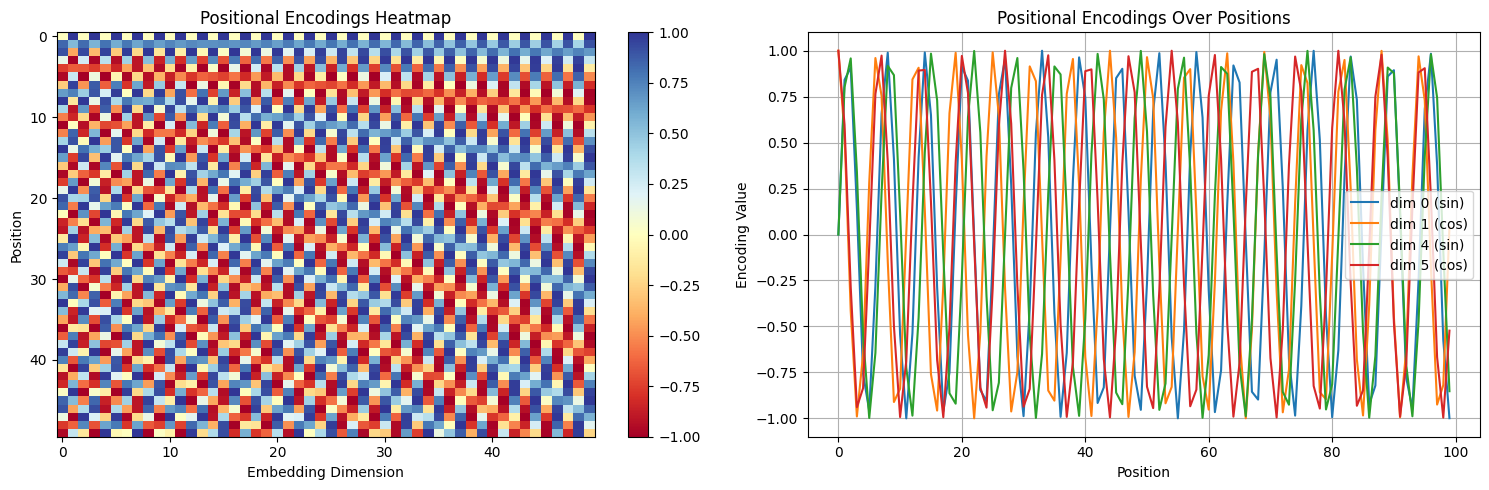

In [15]:
import torch
import torch.nn as nn
import math
import matplotlib.pyplot as plt

def positional_encoding(seq_len, d_model, device='cpu'):
    """
    Generate positional encodings as described in "Attention is All You Need"
    
    Args:
        seq_len (int): Maximum sequence length
        d_model (int): Model dimension (embedding size)
        device (str): Device to create tensor on
        
    Returns:
        torch.Tensor: Positional encoding matrix of shape [seq_len, d_model]
    """
    # Create position indices [0, 1, 2, ..., seq_len-1]
    pos = torch.arange(seq_len, dtype=torch.float32, device=device).unsqueeze(1)
    
    # Create dimension indices [0, 1, 2, ..., d_model//2 - 1]
    i = torch.arange(0, d_model, 2, dtype=torch.float32, device=device)
    
    # Compute the division term: 10000^(2i/d_model)
    div_term = torch.exp(i * -(math.log(10000.0) / d_model))
    
    # Initialize the positional encoding matrix
    pe = torch.zeros(seq_len, d_model, device=device)
    
    # Apply sin to even indices (2i)
    pe[:, 0::2] = torch.sin(pos * div_term)
    
    # Apply cos to odd indices (2i+1)
    pe[:, 1::2] = torch.cos(pos * div_term)
    
    return pe

# Example usage and visualization
if __name__ == "__main__":
    # Parameters
    seq_len = 100
    d_model = 512
    
    # Generate positional encodings
    pe = positional_encoding(seq_len, d_model)
    
    print(f"Positional encoding shape: {pe.shape}")
    print(f"First few values at position 0: {pe[0, :10]}")
    print(f"First few values at position 1: {pe[1, :10]}")
    
    # Visualize the positional encodings
    plt.figure(figsize=(15, 5))
    
    # Plot heatmap of positional encodings
    plt.subplot(1, 2, 1)
    plt.imshow(pe[:50, :50].numpy(), cmap='RdYlBu', aspect='auto')
    plt.xlabel('Embedding Dimension')
    plt.ylabel('Position')
    plt.title('Positional Encodings Heatmap')
    plt.colorbar()
    
    # Plot specific dimensions over positions
    plt.subplot(1, 2, 2)
    positions = torch.arange(seq_len)
    plt.plot(positions, pe[:, 0], label='dim 0 (sin)')
    plt.plot(positions, pe[:, 1], label='dim 1 (cos)')
    plt.plot(positions, pe[:, 4], label='dim 4 (sin)')
    plt.plot(positions, pe[:, 5], label='dim 5 (cos)')
    plt.xlabel('Position')
    plt.ylabel('Encoding Value')
    plt.title('Positional Encodings Over Positions')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

In [16]:
math.sin(0), math.cos(0), math.sin(1)

(0.0, 1.0, 0.8414709848078965)

In [17]:
math.sin(1/10000 ** (4/3))

4.641588833596115e-06

### Training a char-level transformer model on shakespeare

In [18]:
#dataset source: https://archive.org/stream/completeworksofw00shakrich/completeworksofw00shakrich_djvu.txt
raw_data = open('shakespeare.txt', 'r').read()
#raw_data = re.sub(r'\s{2,}', '', raw_data) #too many spaces: classifier learns to simply overweight spaces

itos, stoi = {0: '<br>'}, {'<br>': 0}
for i, char in enumerate(sorted(list(set(raw_data)))):
    itos[i+1] = char
    stoi[char] = i+1

def map_itos(i):
    return itos[i]

def map_stoi(s):
    return stoi[s]

map_itos_vect = np.vectorize(map_itos)
map_stoi_vect = np.vectorize(map_stoi)

n_classes = len(set(raw_data)) + 1
len_raw_data = len(raw_data)

X = map_stoi_vect(np.array(list(raw_data)))

In [19]:
def create_batch(X, batch_size=32, seq_len=20):
    random_idx_arr = np.random.randint(low=0, high=len_raw_data-seq_len, size=batch_size)
    indices = random_idx_arr[:, np.newaxis] + np.arange(seq_len)
    Xb = X[indices]
    return Xb

def create_full_dataset(X, seq_len=20):
    idx_arr = np.arange(X.shape[0] - seq_len)
    indices = idx_arr[:, np.newaxis] + np.arange(seq_len)
    X_full = X[indices]
    return X_full

In [20]:
Xb = create_batch(X, seq_len=100)
print(''.join([itos[i] for i in Xb[0]]))


Mer.   If  traffic  do  it,  the  gods  do  it. 

Apem.  Traffic 's  thy  god,  and  thy  god  con-


In [21]:
#param init
batch_size = 32
d_model = 512
seq_len = 100
n_heads = 8
d_k = d_model // n_heads

E = torch.randn(n_classes, d_model) #embedding matrix, 1 embedding for each class
Wq = torch.randn(d_model, d_model) #query matrix
Wk = torch.randn(d_model, d_model) #key matrix
Wv = torch.randn(d_model, d_model) #value matrix
Wo = torch.randn(d_model, d_model) #output projection matrix
gamma1, beta1 = torch.randn(d_model), torch.zeros(d_model)
gamma2, beta2 = torch.randn(d_model), torch.zeros(d_model)
ff1 = torch.randn(d_model, d_model * 4)
ff2 = torch.randn(d_model * 4, d_model)
ll = torch.randn(d_model, n_classes) / math.sqrt(d_model)

params = [E, Wq, Wk, Wv, Wo, gamma1, beta1, gamma2, beta2, ff1, ff2, ll]
optimizer = optim.SGD(params, lr=0.01)
for p in params:
    p.requires_grad = True

print('number of parameters: ', sum([p.numel() for p in params]))

torch.autograd.set_detect_anomaly(True)

number of parameters:  3259392


In [22]:
#very basic feedforward of a single multi-head attention block

#retrieve batch
Xb = create_batch(X, seq_len=100)
Xb = torch.tensor(Xb)

#embed input data, add positional encodings
pos_enc = positional_encoding(seq_len, d_model)
Xb_embed = E[Xb] + pos_enc

#apply multi-head attention
Q = (Xb_embed @ Wq).view(batch_size, seq_len, n_heads, d_k).transpose(1, 2)
K = (Xb_embed @ Wk).view(batch_size, seq_len, n_heads, d_k).transpose(1, 2)
V = (Xb_embed @ Wv).view(batch_size, seq_len, n_heads, d_k).transpose(1, 2)
scores = Q @ K.transpose(-2, -1) / math.sqrt(d_k)
mask = torch.triu(torch.ones((seq_len, seq_len), dtype=torch.bool))
scores = scores.masked_fill(~mask, -float('inf'))
scores = F.softmax(scores, dim=-1)
attention_pattern = (scores @ V).transpose(1, 2).reshape(batch_size, seq_len, d_model)
Xb_out = attention_pattern @ Wo

#add and layernorm
Xb_embed = Xb_embed + Xb_out
mu = Xb_embed.mean(dim=-1, keepdim=True)
sigma = (Xb_embed + 1e-6).std(dim=-1, keepdim=True)
Xb_embed = (Xb_embed - mu) * gamma1 / sigma + beta1

#apply feedforward layer
Xb_ff = F.relu(Xb_embed @ ff1) @ ff2

#add and layernorm again
Xb_embed = Xb_embed + Xb_ff
mu = Xb_embed.mean(dim=-1, keepdim=True)
sigma = (Xb_embed + 1e-6).std(dim=-1, keepdim=True)
Xb_embed = (Xb_embed - mu) * gamma2 / sigma + beta2


#compute loss
out = F.log_softmax(Xb_embed @ ll, dim=-1)
loss = -torch.gather(out[:, :-1], 2, Xb[:, 1:].unsqueeze(-1)).squeeze(-1).mean()
print('loss: ', loss.item())

#backprop
optimizer.zero_grad()
loss.backward()
optimizer.step()

loss:  5.123324394226074


### Training a char-level transformer model on shakespeare using Pytorch modules

In [89]:
class Net(nn.Module):
    def __init__(self, n_classes, d_model=128, n_heads=16, dropout=0.1, device=None):
        super(Net, self).__init__()
        self.d_model = d_model
        self.e = nn.Embedding(num_embeddings=n_classes, embedding_dim=d_model)
        self.Wq1 = nn.Linear(d_model, d_model)
        self.Wk1 = nn.Linear(d_model, d_model)
        self.Wv1 = nn.Linear(d_model, d_model)
        self.mha1 = nn.MultiheadAttention(
            embed_dim=d_model, 
            num_heads=n_heads, 
            dropout=dropout,
            batch_first=True
        )
        self.ln1 = nn.LayerNorm(d_model)

        self.ffn1 = nn.Sequential(
            nn.Linear(d_model, d_model * 2, bias=True), #upsamples to d_model * 2
            nn.ReLU(),
            nn.Linear(d_model * 2, d_model, bias=True), #downsamples back to d_model
        )
        self.ln2 = nn.LayerNorm(d_model)
        
        self.ll = nn.Linear(d_model, n_classes, bias=False)

    def positional_encodings(self, seq_len):
        """
        Generate positional encodings as described in "Attention is All You Need"
        
        Args:
            seq_len (int): Maximum sequence length
            
        Returns:
            torch.Tensor: Positional encoding matrix of shape [seq_len, d_model]
        """
        # Create position indices [0, 1, 2, ..., seq_len-1]
        pos = torch.arange(seq_len, dtype=torch.float32).unsqueeze(1)
        
        # Create dimension indices [0, 1, 2, ..., d_model//2 - 1]
        i = torch.arange(0, self.d_model, 2, dtype=torch.float32)
        
        # Compute the division term: 10000^(2i/d_model)
        div_term = torch.exp(i * -(math.log(10000.0) / self.d_model))
        
        # Initialize the positional encoding matrix
        pe = torch.zeros(seq_len, self.d_model)
        
        # Apply sin to even indices (2i)
        pe[:, 0::2] = torch.sin(pos * div_term)
        
        # Apply cos to odd indices (2i+1)
        pe[:, 1::2] = torch.cos(pos * div_term)

        device_type = next(self.parameters()).device.type
        if device_type != 'cpu':
            pe = pe.to(device)
        
        return pe
    
    def forward(self, X):
        #retrieve char embeddings
        X = self.e(X)

        #add positional encoding
        seq_len = X.shape[1]
        pe = self.positional_encodings(seq_len)
        X = X + pe

        #apply multihead attention
        Q = self.Wq1(X)
        K = self.Wk1(X)
        V = self.Wv1(X)
        mask = torch.tril(torch.ones((seq_len, seq_len), dtype=torch.bool), diagonal=-1)
        device_type = next(self.parameters()).device.type
        if device_type != 'cpu':
            mask = mask.to(device)
        
        X_mha = self.mha1(query=Q, key=K, value=V, attn_mask=mask)
        X_mha = X_mha[0] #retrieve only attn_output

        #add and norm
        X = X + X_mha
        X = self.ln1(X)

        #apply ffn
        X_ffn = self.ffn1(X)
        #X_ffn = self.fc2(self.relu(self.fc1(X)))

        #add and norm
        X = X + X_ffn
        X = self.ln2(X)

        #apply final linear layer
        X = self.ll(X)
        
        return X

model = Net(n_classes=n_classes)
model = model.to(device)
print('number of parameters: ', sum([p.numel() for p in model.parameters()]))

number of parameters:  209920


In [41]:
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [42]:
#training loop
losses = []
model.train()
for i in range(10000):
    Xb = torch.tensor(create_batch(X, seq_len=100))
    Xb = Xb.to(device)
    out = model(Xb)
    out = F.log_softmax(out, dim=-1)
    loss = -torch.gather(out[:, :-1], 2, Xb[:, 1:].unsqueeze(-1)).squeeze(-1).mean()
    losses.append(loss.item())
    if i % 500 == 0:
        print('loss: ', loss.item())    

    #backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

loss:  4.854949474334717
loss:  2.678571939468384
loss:  2.5197441577911377
loss:  2.5347304344177246
loss:  2.4333291053771973
loss:  2.424705982208252
loss:  2.3752522468566895
loss:  2.363633632659912
loss:  2.2868664264678955
loss:  2.3728530406951904
loss:  2.343762159347534
loss:  2.296666383743286
loss:  2.173224449157715
loss:  2.0381641387939453
loss:  1.6152994632720947
loss:  1.5198369026184082
loss:  1.3049378395080566
loss:  1.070479393005371
loss:  0.9704867005348206
loss:  0.7875437140464783


In [ ]:
raw_stoi = [stoi[c] for c in raw_data]
plt.hist(raw_stoi, bins=109)

In [47]:
X_gen = torch.tensor(create_batch(X, batch_size=1, seq_len=100))
X_gen = X_gen.to(device)

gen_n_chars = 50
smoothing = 1e-2
orig_text = ''.join([itos[c.item()] for c in X_gen[0]])
gen_text = ''
model.eval()
for _ in range(gen_n_chars):
    out = model(X_gen)
    dist = F.softmax(out[0, -1] + smoothing, dim=-1)
    pred = torch.multinomial(dist, num_samples=1).item()
    pred_char = itos[pred]
    gen_text += itos[pred]
    X_gen = torch.tensor(X_gen.tolist()[0][1:] + [pred]).unsqueeze(0)
    X_gen = X_gen.to(device)

print(orig_text + gen_text)

nged  the 
youth  into  dumbness.  This  was  looked  for  at 
your  hand,  and  this  was  baulked                                     ;fffff'ddddddi


In [91]:
#test model accuracy
torch.xpu.empty_cache()
X_test = torch.tensor(create_batch(X, batch_size=1000, seq_len=100)).to(device)
model.eval()
out = model(X_test)
out = F.softmax(out, dim=-1)

preds = out.argmax(dim=-1)[:, :-1]
n_preds = preds.shape[0] * preds.shape[1]

print('model accuracy on test set: ', preds.eq(X_test[:, 1:]).sum().item() / n_preds)

model accuracy on test set:  0.0017171717171717172


In [88]:
#save model
import datetime
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
torch.save(model.state_dict(), f'shakespeare_model_{timestamp}.pt')